# Приоритизация гипотез, запуск A/B-теста и анализ результатов

Мы — аналитики крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Нам будет необходимо:**

1. приоритизовать гипотезы; 

2. запустить A/B-тест;

3. проанализировать результаты.

## Импорт библиотек и ознакомление с данными

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
#Создаем переменные, сохраняем в них таблицы и выводим их
hyp_df = pd.read_csv('/datasets/hypothesis.csv')
display(hyp_df)

orders = pd.read_csv('/datasets/orders.csv')
display(orders.head())

visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [3]:
#Выводим общую информацию о таблицах
display(hyp_df.info())

display(orders.info())

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


После вывода общей информации о таблицах видно, что:

1. в названиях столбцов используются заглавные буквы, что может привести к ошибкам;

2. в таблицах `orders` и `visitors` неверный тип данных в столбцах с датами;

**Подготовим данные к исследованию.**

## Предобработка данных

In [4]:
#Приводим названия столбцов к удобному виду
hyp_df.columns = hyp_df.columns.str.lower()
display(hyp_df.columns)

orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'transactionid' : 'transaction_id', 'visitorid' : 'visitor_id'})
orders.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [5]:
#Изменяем типы данных
orders['date'] = pd.to_datetime(orders['date'])

visitors['date'] = pd.to_datetime(visitors['date'])

In [6]:
#Проверяем наличие явных дубликатов
print('количество явных дубликатов в таблице hyp_df:', hyp_df.duplicated().sum())
print()

print('количество явных дубликатов в таблице orders:', orders.duplicated().sum())
print()

print('количество явных дубликатов в таблице visitors:', visitors.duplicated().sum())

количество явных дубликатов в таблице hyp_df: 0

количество явных дубликатов в таблице orders: 0

количество явных дубликатов в таблице visitors: 0


In [7]:
#Проверяем изменения
display(hyp_df.info())

display(orders.info())

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Произвели предобработку данных:

1. привели названия столбцов к удобному виду;

2. изменили тип данных в столбцах с датами;

3. проверили наличие дубликатов - отсутсвуют;

4. проверили наличие пропусков - отсутсвуют;

**Данные готовы к исследованию.**

## Приоритизация гипотез

In [8]:
#Применяем фреймоврки ICE и RICE для приоритизации гипотез
pd.set_option('display.max_colwidth', 0)

display(hyp_df)

hyp_df['ICE'] = (hyp_df['impact'] * hyp_df['confidence']) / hyp_df['efforts']

hyp_df['RICE'] = (hyp_df['reach'] * hyp_df['impact'] * hyp_df['confidence']) / hyp_df['efforts']

display(hyp_df[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

display(hyp_df[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Мы произвели приоритизацию гипотез с помощью фреймворков ICE и RICE и можем сделать следующие выводы:

1. гипотезы с ID 7 (*добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*) и 0 (*добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей*) показывают себя достаточно хорошо из-за высоких показателей `reach` и `impact` соответственно;


2. гипотеза с ID 8 (*запустить акцию, дающую скидку на товар в день рождения*) опустилась вниз из-за низкого значения `reach` (охват);


3. остальные гипотезы остались на примерно тех же местах;


Основные изменения произошли из-за включения парметра `reach` в подсчет. 

**Я предлагаю проверить теорию с ID 7 (*добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*), так как у нее самый большой охват и небольшие затраты.**

## Анализ А/В теста

### подготовка данных к составлению графиков:

In [9]:
#создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

#получаем агрегированные кумулятивные данные о заказах
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], 
            orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

#получаем агрегированные кумулятивные данные о посетителях
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], 
            visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

#объединяем кумулятивные данные в одной таблице и присваиваем столбцам удобные названия
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

#таблица с кумулятивным количеством заказов и кумулятивной выручкой в группах
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

### график кумулятивной выручки по группам:

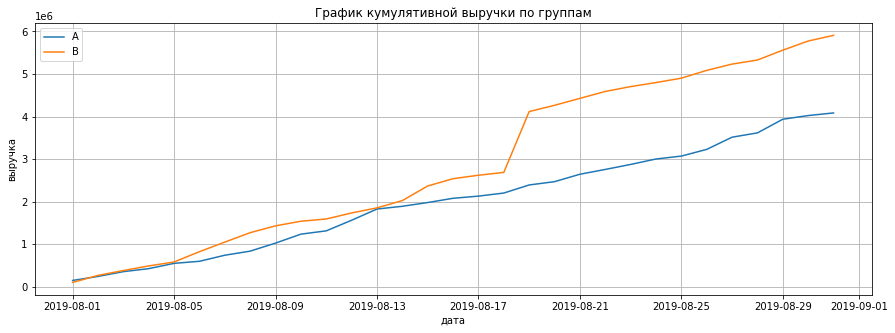

In [10]:
plt.figure(figsize=(15, 5))

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.legend()
plt.grid()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('дата')
plt.ylabel('выручка');

Выручка почти равномерно увеличивается в течение всего теста. Однако график выручки группы "В" в одной точках резко растет. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. График группы "А" растет равномерно на протяжении всего теста.

### график кумулятивного среднего чека по группам:

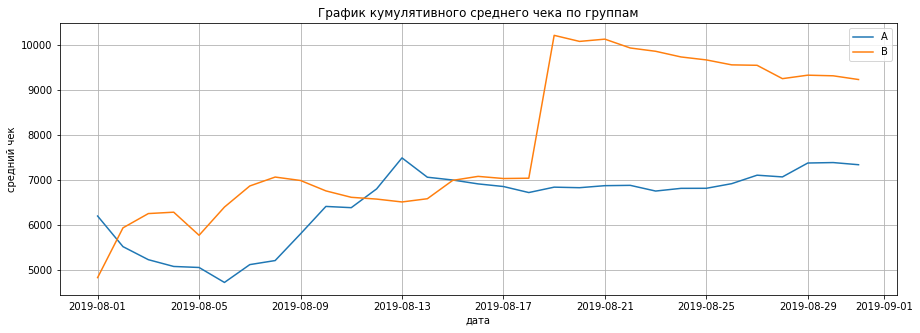

In [11]:
plt.figure(figsize=(15, 5))

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')

plt.legend()
plt.grid()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('дата')
plt.ylabel('средний чек');

Кумулятивное значение среднего чека у группы "В" также резко вырастает 18 августа, как и на предыдущем графике. Надо будет ниже анализировать выбросы, по такой выборке делать выводы рано. График группы "А" нестабилен: сначала падает, потом растет, затем выходит на плато.

### график относительного изменения кумулятивного среднего чека группы B к группе A:

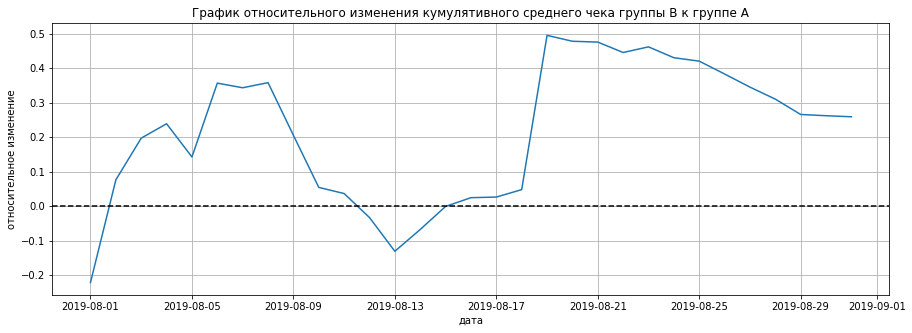

In [12]:
#создаем таблицу средних чеков групп
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

plt.figure(figsize=(15, 5))

plt.plot(
    merged_cumulative_revenue['date'], 
    (merged_cumulative_revenue['revenueB'] 
     / merged_cumulative_revenue['ordersB']) 
    / (merged_cumulative_revenue['revenueA'] 
       / merged_cumulative_revenue['ordersA']) 
    - 1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')
plt.ylabel('относительное изменение');

Опять же видим резкий скачок 18 августа - скорее всего в этот день был совершен крупный заказ.

### график кумулятивного среднего количества заказов по группам:

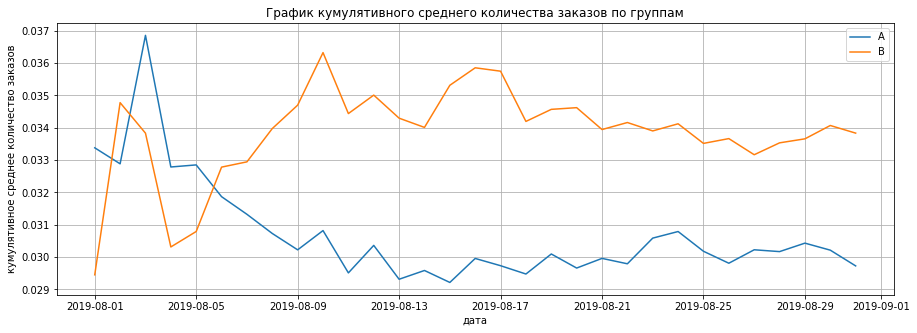

In [13]:
#добавляем столбец конверсии, то есть оформления заказа
cumulative_data['avg_orders'] = cumulative_data['orders'] / cumulative_data['visitors']

cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']

cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

plt.figure(figsize=(15, 5))

plt.plot(cumulative_data_a['date'], cumulative_data_a['avg_orders'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['avg_orders'], label='B')

plt.legend()
plt.grid()
plt.title('График кумулятивного среднего количества заказов по группам')
plt.xlabel('дата')
plt.ylabel('кумулятивное среднее количество заказов');

В начале теста сегмент "А" имел большее среднее количество заказов, но затем сегмент "В" 6 августа вырвался вперед и зафиксировался на примерном уровне 0.034. Сегмент "А" также стабилизировался на показателе 0.03. Вначале исследования оба сегмента показывали себя нестабильно, но затем стабилизировались.

### график относительного изменения кумулятивного среднего количества заказов группы B к группе A:

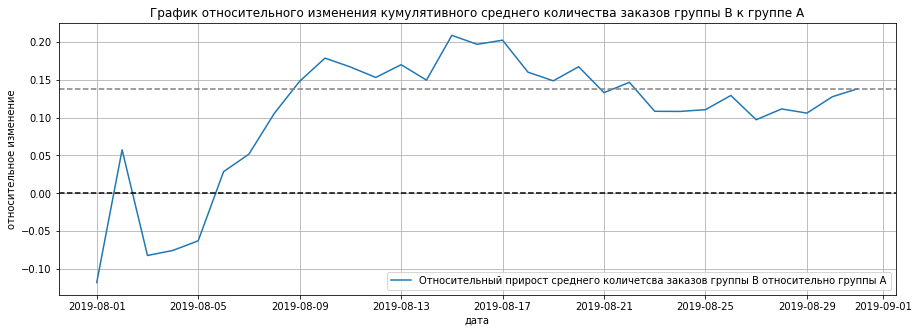

In [14]:
#строим таблицу кумулятивных данных групп
merged_cumulative_conversions = (
    cumulative_data_a[['date', 'avg_orders']]
    .merge(cumulative_data_b[['date', 'avg_orders']], 
           left_on='date', 
           right_on='date', 
           how='left', 
           suffixes=['A', 'B']
          )
)

plt.figure(figsize=(15, 5))

plt.plot(
    merged_cumulative_conversions['date'], 
    merged_cumulative_conversions['avg_ordersB'] / merged_cumulative_conversions['avg_ordersA'] - 1, 
    label='Относительный прирост среднего количетсва заказов группы B относительно группы A'
)

plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.138, color='grey', linestyle='--')
plt.grid()
plt.title('График относительного изменения кумулятивного среднего количества заказов группы B к группе A')
plt.xlabel('дата')
plt.ylabel('относительное изменение');

Группа "В" почти сразу вышла в лидеры и показывает результаты на 13.8% лучше группы "А".

### точечный график количества заказов по пользователям:

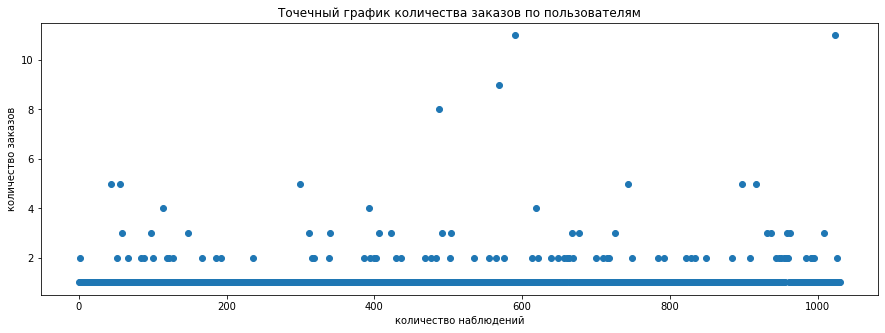

In [15]:
#создаем таблицу с пользоватлеями и их количеством заказов
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

#создаем переменную равную серии чисел от 0 до количества наблюдений в orders_вy_users
x_values = pd.Series(range(0, len(orders_by_users)))

#выводим график
plt.figure(figsize=(15, 5))

plt.scatter(x_values, orders_by_users['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('количество наблюдений')
plt.ylabel('количество заказов');

По графику видим, что основная часть визиторов не делала заказ больше 2 раз.

### 95-й и 99-й перцентили количества заказов на пользователя:

In [16]:
#методом percentile из библиотеки NumPy считаем перцентили
print('95% пользователей совершили', round(np.percentile(orders_by_users['orders'], 95)), 'и менее заказов')
print()
print('99% пользователей совершили', round(np.percentile(orders_by_users['orders'], 99)), 'и менее заказов')

95% пользователей совершили 2 и менее заказов

99% пользователей совершили 4 и менее заказов


Эти цифры подтверждают вывод выше: только 5% визиторов делали больше 2 закзов и только 1% больше 4. 

Следовательно, можем сделать вывод, что **совершение 3 и более заказов будем считатеть аномалией.**

### точечный график стоимостей заказов:

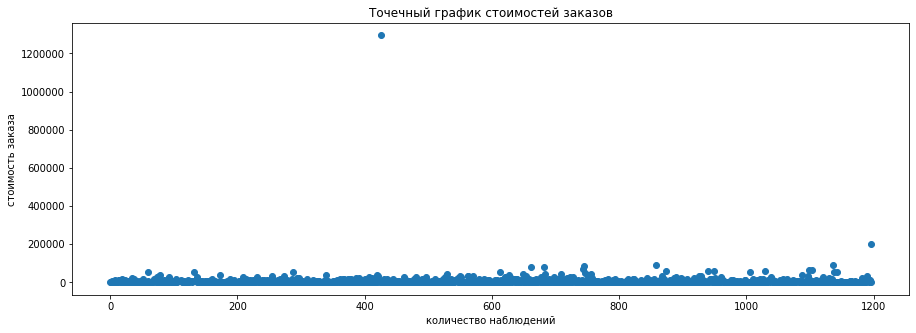

In [17]:
#создаем переменную равную серии чисел от 0 до количества наблюдений в orders['revenue']
x_values = pd.Series(range(0, len(orders['revenue'])))

#выводим график
plt.figure(figsize=(15, 5))

plt.scatter(x_values, orders['revenue'])

plt.ticklabel_format(axis='y', style='plain')
plt.title('Точечный график cтоимостей заказов')
plt.xlabel('количество наблюдений')
plt.ylabel('стоимость заказа');

По графику мы видим, что основная часть заказов находится около 0, из-за маштаба плохо видно, но мы рассмотрим этот график ближе ниже, а пока мы видим, что есть явные выбросы - заказ на 1.200.000.

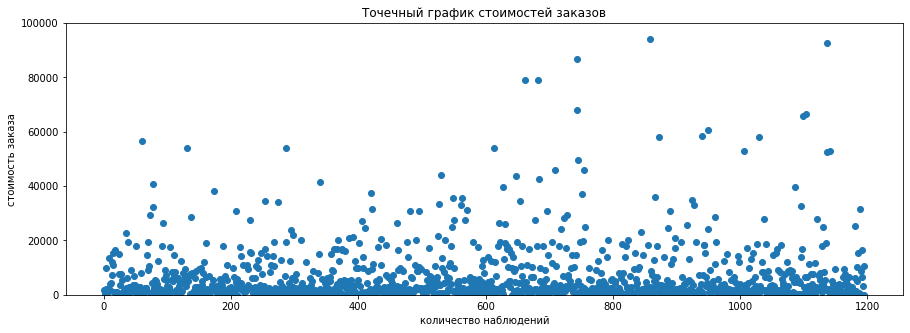

In [18]:
plt.figure(figsize=(15, 5))

plt.scatter(x_values, orders['revenue'])

plt.ticklabel_format(axis='y', style='plain')
plt.title('Точечный график cтоимостей заказов')
plt.xlabel('количество наблюдений')
plt.ylabel('стоимость заказа')
plt.ylim(0, 100000);

Уменьшив маштаб, мы видим, что основная доля заказов не превышает по стоимости 30.000.

### 95-й и 99-й перцентили стоимости заказов:

In [19]:
#методом percentile из библиотеки NumPy считаем перцентили
print('95% заказов стоят менее', round(np.percentile(orders['revenue'], 95)))
print()
print('99% заказов стоят менее', round(np.percentile(orders['revenue'], 99)))

95% заказов стоят менее 28000

99% заказов стоят менее 58233


По цифрам мы видим, что основные заказы приходятся на стоимость до 28.000, больше этой суммы заказывает только 5% пользователей и 1% заказывает на суммы более 58.000. Наши выводы выше также подтвердились!

**Будем считать, что стоимость заказа более 28.000 является аномалией.**

### подготовка данных к расчету статестически значимых различий:

In [20]:
#создаем таблицу с дневным посещением для группы А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

#создаем таблицу с дневным кумулятивным посещением для группы А
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

#создаем таблицу с дневным посещением для группы B
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

#создаем таблицу с дневным кумулятвным посещением для группы B
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

#создаем таблицу с дневным количеством заказов для группы А
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

#создаем таблицу с дневным кумулятивным количеством заказов для группы А
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

#создаем таблицу с дневным количеством заказов для группы В
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

#создаем таблицу с дневным кумулятивным количеством заказов для группы В
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

#Объединяем все данные в одну таблицу
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

#считаем заказы по юзерам для группы А
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique})
)

orders_by_users_a.columns = ['user_id', 'orders']

#считаем заказы по юзерам для группы А
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique})
)

orders_by_users_b.columns = ['user_id', 'orders']

#переменная, в которой пользователям из группы А будет соответствовать количество заказов
sample_a = pd.concat(
    [
        orders_by_users_a['orders'], 
        pd.Series(
            0, 
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ), 
            name='orders',
        ),
    ], 
    axis=0,
)

#переменная, в которой пользователям из группы В будет соответствовать количество заказов
sample_b = pd.concat(
    [
        orders_by_users_b['orders'], 
        pd.Series(
            0, 
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ), 
            name='orders',
        ),
    ], 
    axis=0,
)

Сформулируем гипотезы, которые будем проверять ниже:

Н0: между группами "А" и "В" нет статестических важных различий в среднем количестве заказов и в среднем чеке заказа

Н1: между группами "А" и "В" есть статестически важные различия в среднем количестве заказов и в среднем чеке заказа

### статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным:

Сделаем несколько ремарок, далее в исселодовании везде будут применятся такие параметры:

1. уровень alpha установим равный 0.05;

2. в ходе исследования будем пользоваться статистическим U-критерием Манна-Уитни.

Сформулируем гипотезы, которые будем проверять ниже (по сырым данным):

Н0: между группами "А" и "В" нет статестических важных различий в среднем количестве заказов

Н1: между группами "А" и "В" есть статестически важные различия в среднем количестве заказов

In [21]:
alpha = .05

results = stats.mannwhitneyu(sample_a, sample_b)

In [22]:
#выводим p-value и отношение среднего количества заказов
print('p-значение: ', round(results.pvalue, 3))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print()    
print('Относительная победа группы "В" равна:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-значение:  0.017
Отвергаем нулевую гипотезу: разница статистически значима

Относительная победа группы "В" равна: 0.138


Данные цифры нам говорят, что в среднем количестве заказов между группами есть статестически значимые различия, а среднее количество заказов группы "В" по отношению к группе "А" на 13.8% выше, что тоже является подтверждением наших выводов выше.

### статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным:

Сформулируем гипотезы, которые будем проверять ниже (по сырым данным):

Н0: между группами "А" и "В" нет статестических важных различий в среднем чеке заказа

Н1: между группами "А" и "В" есть статестически важные различия в среднем чеке заказа

In [23]:
results = stats.mannwhitneyu(
    orders[orders['group'] == 'A']['revenue'], 
    orders[orders['group'] == 'B']['revenue']
)

In [24]:
#выводим p-value и различие в среднем чеке заказа
print('p-значение: ', round(results.pvalue, 3))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print()
print(
    'Относительная победа группы "В" над группой "А" равна:',
    '{0:.3f}'.format(orders[orders['group'] == 'B']['revenue']
    .mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1)
)

p-значение:  0.729
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительная победа группы "В" над группой "А" равна: 0.259


p-value сильно больше 0.05, значит, что различий в среднем чеке между группами нет. А наблюдаемое превышение среднего чека группы "В" на почти 26% выше среднего чека группы "А" не является значимым, было получено случайно. 

### очистка данных от выбросов:

Основываясь на данных, полученных выше, принимаем аномальными значениями:

1. количество заказов равное 3 и выше;
2. стоимость заказа более 28.000.

In [25]:
#создаем таблицу с юзерами, у которых более 2 заказов
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > np.percentile(orders_by_users['orders'], 95)]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > np.percentile(orders_by_users['orders'], 95)]['user_id'],
    ],
    axis=0,
)

#создаем таблицу с юзерами, у которых стоимость заказа более 28000
users_with_expensive_orders = orders[orders['revenue'] > (np.percentile(orders['revenue'], 95))]['visitor_id']

#объединяем таблицы
a_b_normal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [26]:
#создаем отфильтрованные таблицы двух групп
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(a_b_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(a_b_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

### статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным:

Сформулируем гипотезы, которые будем проверять ниже (по очищенным данным):

Н0: между группами "А" и "В" нет статестических важных различий в среднем количестве заказов

Н1: между группами "А" и "В" есть статестически важные различия в среднем количестве заказов

In [27]:
results = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)

In [28]:
print('p-значение: ', round(results.pvalue, 3))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print()

print('Относительная победа группы "В" равна:', '{0:.3f}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

p-значение:  0.013
Отвергаем нулевую гипотезу: разница статистически значима

Относительная победа группы "В" равна: 0.173


Очистка данных сделала ситуацию еще лучше. Статистическая значимость достигнута, значит, сегмент "В" по среднему количеству заказов лучше сегмента "А" (причем на 17.3%).

### статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным:

Сформулируем гипотезы, которые будем проверять ниже (по очищенным данным):

Н0: между группами "А" и "В" нет статестических важных различий в среднем чеке заказа

Н1: между группами "А" и "В" есть статестически важные различия в среднем чеке заказа

In [29]:
results = stats.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitor_id'].isin(a_b_normal_users)),
        )
    ]['revenue'],
    orders[
         np.logical_and(
              orders['group'] == 'B',
              np.logical_not(orders['visitor_id'].isin(a_b_normal_users)),
       )
     ]['revenue'],
 )

In [30]:
print('p-значение: ', round(results.pvalue, 3))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print()

print(
    'Относительная победа группы "В" над группой "А" равна:',
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(a_b_normal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(a_b_normal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-значение:  0.738
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительная победа группы "В" над группой "А" равна: -0.020


Видим как фильтрация изменила наши данные, в общем плане ничего не изменилось, но средний чек заказа группы "В" стал на 2% хуже чем у группы "А". Но гипотеза о том, что это никак не влияет на статистиу подтвердилась - мы не можем сделать выводы о различии двух групп по этому критерию.

## Принятие решения по результатам теста

Исходя из имеющихся фактов:

1. есть статистически значимое различие в среднем количестве заказов между группами как по сырым данным, так и после фильтрации аномалий;

2. нет статистически значимого различия в среднем чеке заказа между группами как по сырым данным, так и после фильтрации аномалий;

3. график относительного изменения кумулятивного среднего количества заказов между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения;

4. график различия среднего чека колеблется - сделать из этого графика определённые выводы нельзя (после фильтрации значения сильно изменлись).

Исходя из всего выше перечисленного делаем вывод, что группа "В" является победителем и **принимаем решение: остановить тест и признать его успешным!**

## Вывод

1. Вначале исследования мы произвели проверку гипотез с помощью фреймворков `ICE` и `RICE` и пришли к выводу, что гипотеза с ID номером 7 достаточно перспективная: у нее хороший охват и совсем небольшие затраты;

2. Далее мы перешли к проверке результатов А/В теста:

    * мы построили графики и увидели, что показатели группы "В" лучше показателей группы "А" (кумулятивный чек, кумулятивная выручка, кумулятивное среднее количество заказов выше у группы "В");
    * обнаружили странности со средним чеком группы "В" и произвели очитску от аномальных значений;
    * после проведения фильтрации наши выводы почти не изменились, но было выявлено, что у группы "В" средний чек на 2% хуже, чем у группы "А", но это не повлияло на общие результаты теста;
    
3. По итогам теста группа "В" показала результаты, а именно:
    
    * среднее количество заказов у группы "В" выше, чем у группы "А" на 17%;
    * средний чек после фильтрации данных на 2% хуже, чем у группы "А", но этот показатель не имеет статестической значимости

и было принято решение завершить тестирование и признать его успешным.